In [1]:
import copy
import numpy as np
import pandas as pd
from datetime import datetime
from numpy import linalg as LA
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import networkx as nx

In [2]:
def plotFMI(G, show_IDs=True, nodes_red=[]): 
    coords = np.array([G.nodes[node]['coord'] for node in G.nodes])

    fig, ax = plt.subplots(figsize=(10, 8))
    
    for node, (lat, lon) in enumerate(coords):
        user_name = G.nodes[node]['user_name']
        if user_name != None:
            if node in nodes_red:
                ax.scatter(coords[node, 1], coords[node, 0], color='red', s=10, zorder=5)
            else:
                ax.scatter(coords[node, 1], coords[node, 0], color='blue', s=10, zorder=5)
            ax.text(lon + 0.7, lat - 0.5, user_name, fontsize=16, ha='center', va='center', color='blue', fontweight='bold')
        else:
            if node in nodes_red:
                ax.scatter(coords[node, 1], coords[node, 0], color='red', s=10, zorder=5)
            else:
                ax.scatter(coords[node, 1], coords[node, 0], color='black', s=10, zorder=5)
            if show_IDs:
                ax.text(lon + 0.1, lat + 0.2, str(node), fontsize=8, ha='center', va='center', color='black', fontweight='bold')

    for u, v in G.edges:
        ax.plot([coords[u, 1], coords[v, 1]], [coords[u, 0], coords[v, 0]], linestyle='-', color='gray')

    ax.set_xlim(18.5, 31.5)
    ax.set_ylim(59, 71)

    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_title('FMI stations')

    ax.set_aspect(1.6)
    plt.show()
    
def add_edges(G, numneighbors=4):
    graph_with_edges = copy.deepcopy(G)

    coords = np.array([graph_with_edges.nodes[node]['coord'] for node in graph_with_edges.nodes])

    adjacency_matrix = kneighbors_graph(coords, numneighbors, mode='connectivity', include_self=False)

    edges = zip(*adjacency_matrix.nonzero())

    graph_with_edges.add_edges_from(edges)

    return graph_with_edges

def ExtractFeatureMatrixLabelVector(data):
    temps = data['temp'].values
    latitudes = data['Latitude'].values / 100
    longitudes = data['Longitude'].values / 100

    timestamps = data['Timestamp']
    year = timestamps.dt.year / 2025
    month = timestamps.dt.month / 13
    day = timestamps.dt.day / 32
    hour = timestamps.dt.hour / 25
    minute = timestamps.dt.minute / 61

    X = np.column_stack([latitudes, longitudes, year, month, day, hour, minute])
    y = temps.reshape(-1, 1)

    return X, y

In [3]:
seed = 4740

data = pd.read_csv('fmi_data.csv')
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

n_stations = len(data.name.unique())

The empirical graph is connected: True


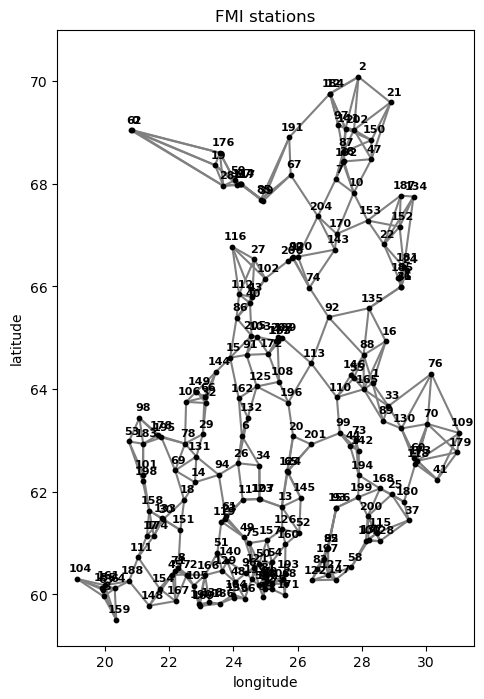

In [4]:
G_FMI_no_edges = nx.Graph()

G_FMI_no_edges.add_nodes_from(range(n_stations))

for i, station in enumerate(data.name.unique()):
    station_data = data[data.name==station]
    
    X_node, y_node = ExtractFeatureMatrixLabelVector(station_data)
    
    X_train, X_test, y_train, y_test = train_test_split(X_node, y_node, test_size=0.2, random_state=seed)

    G_FMI_no_edges.nodes[i].update({
        'name': station,
        'user_name': None,
        'coord': (station_data.Latitude.iloc[0], station_data.Longitude.iloc[0]),
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })
    
G_FMI = add_edges(G_FMI_no_edges, numneighbors=4)
print("The empirical graph is connected:", nx.is_connected(G_FMI))

plotFMI(G_FMI)

## FedGD 

In [5]:
def FedGD(graph_FMI, 
          alpha=0.5, 
          l_rate=0.1, 
          max_iter=1000, 
          tol=0.0001, 
          logging=False):
    graph = copy.deepcopy(graph_FMI)
    
    for node in graph.nodes:
        graph.nodes[node]['weights'] = np.zeros((graph.nodes[node]['X_train'].shape[1], 1))

    prev_avg_delta_w = 1001
    curr_avg_delta_w = 1000
    i = 0
    while i < max_iter and prev_avg_delta_w - curr_avg_delta_w > tol:
        delta_w = {}
        updates = {}
        for node in graph.nodes:
            X_train, y_train = graph.nodes[node]['X_train'], graph.nodes[node]['y_train']
            w_current = graph.nodes[node]['weights']
            term_1 = (2 / len(y_train)) * X_train.T.dot(X_train.dot(w_current) - y_train)
            term_2 = 2 * alpha * sum(
                w_current - graph.nodes[neighbor]['weights'] for neighbor in graph.neighbors(node)
            )
            updates[node] = w_current - l_rate * (term_1 + term_2)

        for node, new_weights in updates.items():
            delta_w[node] = np.linalg.norm(graph.nodes[node]['weights'] - new_weights)
            graph.nodes[node]['weights'] = new_weights

        prev_avg_delta_w = curr_avg_delta_w
        curr_avg_delta_w = np.array(list(delta_w.values())).mean()
        if logging:
            print(f"Iteration #{i}: avg_delta_w = {curr_avg_delta_w}")

        i += 1

    if i == max_iter:
        print(f"Maximum iteration reached\n")
    else:
        print(f"Convergence reached at iteration #{i}\n")

    return graph

### Task 1 Subjective Explainability

In [6]:
np.random.seed(seed)
for node in G_FMI.nodes:
    y_test = G_FMI.nodes[node]['y_test']
    noise = y_test * np.random.uniform(-0.01, 0.01)
    G_FMI.nodes[node]['u'] = y_test + noise

In [7]:
def FedGD_Exp(graph_FMI, 
              alpha=0.5, 
              rho=0.5, 
              l_rate=0.05, 
              max_iter=1000, 
              tol=0.0001, 
              logging=False):
    graph = copy.deepcopy(graph_FMI)

    for node in graph.nodes:
        graph.nodes[node]['weights'] = np.zeros((graph.nodes[node]['X_train'].shape[1], 1))

    prev_avg_delta_w = 1001
    curr_avg_delta_w = 1000
    i = 0
    while i < max_iter and prev_avg_delta_w - curr_avg_delta_w > tol:
        delta_w = {}
        updates = {}
        for node in graph.nodes:
            X_train, y_train = graph.nodes[node]['X_train'], graph.nodes[node]['y_train']
            X_test, user_signals = graph.nodes[node]['X_test'], graph.nodes[node]['u']
            w_current = graph.nodes[node]['weights']

            # Training error gradient
            term_1 = (2 / len(y_train)) * X_train.T.dot(X_train.dot(w_current) - y_train)

            # Subjective explainability gradient
            term_2 = (2 * rho / len(user_signals)) * X_test.T.dot(X_test.dot(w_current) - user_signals)

            # Graph regularization gradient
            term_3 = 2 * alpha * sum(
                w_current - graph.nodes[neighbor]['weights'] for neighbor in graph.neighbors(node)
            )
            
            # Update rule
            updates[node] = w_current - l_rate * (term_1 + term_2 + term_3)

        # Apply updates synchronously
        for node, new_weights in updates.items():
            delta_w[node] = np.linalg.norm(graph.nodes[node]['weights'] - new_weights)
            graph.nodes[node]['weights'] = new_weights

        prev_avg_delta_w = curr_avg_delta_w
        curr_avg_delta_w = np.array(list(delta_w.values())).mean()
        if logging:
            print(f"Iteration #{i}: avg_delta_w = {curr_avg_delta_w}")

        i += 1

    if i == max_iter:
        print(f"Maximum iteration reached\n")
    else:
        print(f"Convergence reached at iteration #{i}\n")
        
    return graph

In [8]:
graph_trained_Exp = FedGD_Exp(G_FMI, 
                              alpha=0.5, 
                              rho=0.5, 
                              l_rate=0.05, 
                              max_iter=1000, 
                              tol=0.0001, 
                              logging=False)

weights_data_Exp = np.array([graph_trained_Exp.nodes[node]['weights'] for node in graph_trained_Exp.nodes])

graph_trained = FedGD(G_FMI, 
                      alpha=0.5, 
                      l_rate=0.05, 
                      max_iter=1000, 
                      tol=0.0001, 
                      logging=False)

weights_data = np.array([graph_trained.nodes[node]['weights'] for node in graph_trained.nodes])

print(f"Basic FedGD: the final weights for the node #0 is\n{weights_data[0]}\n")
print(f"FedGD with Subjective Explainability term: the final weights for the node #0 is\n{weights_data_Exp[0]}\n")

def test_FedGD_Exp(graph_FMI, 
                   alpha=0.5, 
                   rho=0.5, 
                   l_rate=0.05, 
                   max_iter=1000, 
                   tol=0.0001):
    
    graph = copy.deepcopy(graph_FMI)

    for node in graph.nodes:
        graph.nodes[node]['weights'] = np.zeros((graph.nodes[node]['X_train'].shape[1], 1))

    prev_avg_delta_w = 1001
    curr_avg_delta_w = 1000
    i = 0
    while i < max_iter and prev_avg_delta_w - curr_avg_delta_w > tol:
        delta_w = {}
        updates = {}
        for node in graph.nodes:
            X_train, y_train = graph.nodes[node]['X_train'], graph.nodes[node]['y_train']
            X_test, user_signals = graph.nodes[node]['X_test'], graph.nodes[node]['u']
            w_current = graph.nodes[node]['weights']

            term_1 = (2 / len(y_train)) * X_train.T.dot(X_train.dot(w_current) - y_train)

            term_2 = (2 * rho / len(user_signals)) * X_test.T.dot(X_test.dot(w_current) - user_signals)

            term_3 = 2 * alpha * sum(
                w_current - graph.nodes[neighbor]['weights'] for neighbor in graph.neighbors(node)
            )

            updates[node] = w_current - l_rate * (term_1 + term_2 + term_3)

        for node, new_weights in updates.items():
            delta_w[node] = np.linalg.norm(graph.nodes[node]['weights'] - new_weights)
            graph.nodes[node]['weights'] = new_weights

        prev_avg_delta_w = curr_avg_delta_w
        curr_avg_delta_w = np.array(list(delta_w.values())).mean()

        i += 1
        
    return graph

test_graph_trained_Exp = test_FedGD_Exp(G_FMI, 
                                        alpha=0.5, 
                                        rho=0.5, 
                                        l_rate=0.05, 
                                        max_iter=1000, 
                                        tol=0.0001)

test_weights_data_Exp = np.array([test_graph_trained_Exp.nodes[node]['weights'] for node in test_graph_trained_Exp.nodes])

test_weights_84 = test_weights_data_Exp[84]
weights_84 = weights_data_Exp[84]
np.testing.assert_allclose(actual=weights_84, 
                           desired=test_weights_84, 
                           rtol=0.01, 
                           atol=0)

Convergence reached at iteration #238

Convergence reached at iteration #279

Basic FedGD: the final weights for the node #0 is
[[ -7.41060299]
 [ -2.80323943]
 [-10.90673419]
 [  0.95166388]
 [  0.13977734]
 [ -0.66909056]
 [  0.        ]]

FedGD with Subjective Explainability term: the final weights for the node #0 is
[[-7.35192709e+00]
 [-2.79042271e+00]
 [-1.08154663e+01]
 [ 1.27947524e+00]
 [ 2.32488878e-03]
 [-3.95875273e-02]
 [ 0.00000000e+00]]



## FedGD with Zero-Loss Nodes

### Task 2 Privacy Attack- Where is Alice?

In [9]:
reference_date = pd.Timestamp(year=2023, month=12, day=1)

data["winter_day"] = (data["Timestamp"] - reference_date).dt.days

daily_avg_temp = data.groupby(["winter_day", "name"]).agg(
    avg_temp=("temp", "mean"),
    Latitude=("Latitude", "first"),
    Longitude=("Longitude", "first"),
).reset_index()

scaler_winter_day = StandardScaler()
scaler_avg_temp = StandardScaler()
daily_avg_temp['winter_day_scaled'] = scaler_winter_day.fit_transform(daily_avg_temp['winter_day'].values.reshape(-1, 1))
daily_avg_temp['avg_temp_scaled'] = scaler_avg_temp.fit_transform(daily_avg_temp['avg_temp'].values.reshape(-1, 1))

print(f"The data point example:")
print(daily_avg_temp[daily_avg_temp['name'] == 'Alajärvi Möksy'])

G_Alice_Bob = copy.deepcopy(G_FMI_no_edges)
for node, attrs in G_Alice_Bob.nodes(data=True):
    station = attrs['name']
    station_data = daily_avg_temp[daily_avg_temp['name'] == station]
    X_train = station_data['winter_day_scaled'].values.reshape(-1, 1)
    y_train = station_data['avg_temp_scaled'].values.reshape(-1, 1)
    G_Alice_Bob.nodes[node]['X_train'] = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    G_Alice_Bob.nodes[node]['y_train'] = y_train

    G_Alice_Bob.nodes[node].pop('X_test', None)
    G_Alice_Bob.nodes[node].pop('y_test', None)

The data point example:
     winter_day            name   avg_temp  Latitude  Longitude  \
0            27  Alajärvi Möksy  -5.784615  63.08898   24.26084   
207          28  Alajärvi Möksy  -6.895833  63.08898   24.26084   
413          29  Alajärvi Möksy -13.479167  63.08898   24.26084   
619          30  Alajärvi Möksy -19.916667  63.08898   24.26084   
826          31  Alajärvi Möksy -24.636364  63.08898   24.26084   

     winter_day_scaled  avg_temp_scaled  
0            -1.413872         0.782669  
207          -0.707278         0.631292  
413          -0.000684        -0.265531  
619           0.705910        -1.142488  
826           1.412504        -1.785435  


In [10]:
def FedGD_zero_loss(graph_FMI, 
                    zero_loss_nodes=[], 
                    alpha=0.5, 
                    l_rate=0.1,
                    max_iter=1000, 
                    tol=0.0001, 
                    logging=False, 
                    n_init=5):
    best_graph = None
    best_avg_loss = float('inf')
    
    np.random.seed(seed)
    for init_iter in range(n_init):
        print(f"Running initialization {init_iter + 1}/{n_init}")

        graph = copy.deepcopy(graph_FMI)
        
        for node in graph.nodes:
            graph.nodes[node]['weights'] = np.random.uniform(-1, 1, (graph.nodes[node]['X_train'].shape[1], 1))

        prev_avg_delta_w = 1001
        curr_avg_delta_w = 1000
        i = 0
        while i < max_iter and prev_avg_delta_w - curr_avg_delta_w > tol:
            delta_w = {}
            updates = {}
            for node in graph.nodes:
                X_train, y_train = graph.nodes[node]['X_train'], graph.nodes[node]['y_train']
                w_current = graph.nodes[node]['weights']
                term_1 = (2 / len(y_train)) * X_train.T.dot(X_train.dot(w_current) - y_train)
                term_2 = 2 * alpha * sum(
                    w_current - graph.nodes[neighbor]['weights'] for neighbor in graph.neighbors(node)
                )
                if node in zero_loss_nodes:
                    updates[node] = w_current - l_rate * term_2
                else:
                    updates[node] = w_current - l_rate * (term_1 + term_2)

            for node, new_weights in updates.items():
                delta_w[node] = np.linalg.norm(graph.nodes[node]['weights'] - new_weights)
                graph.nodes[node]['weights'] = new_weights
                
            prev_avg_delta_w = curr_avg_delta_w
            curr_avg_delta_w = np.array(list(delta_w.values())).mean()
            if logging:
                print(f"Iteration #{i}: avg_delta_w = {curr_avg_delta_w}")

            i += 1

        avg_loss = 0
        for node, attr in graph.nodes(data=True):
            local_loss = mean_squared_error(attr['y_train'], attr['X_train'].dot(attr['weights']))
            avg_loss += local_loss
        avg_loss /= len(graph.nodes)
        
        if avg_loss < best_avg_loss:
            print(f"The best loss is updated: {avg_loss}")
            best_avg_loss = avg_loss
            best_graph = graph

        if i == max_iter:
            print(f"Initialization {init_iter + 1}: Maximum iteration reached\n")
        else:
            print(f"Initialization {init_iter + 1}: Convergence reached at iteration #{i}\n")

    return best_graph

### Alice

In [11]:
Alice_node_id = 0
for node_id, attrs in G_Alice_Bob.nodes(data=True):
    if attrs['name'] == "Vantaa Helsinki-Vantaan lentoasema":
        Alice_node_id = node_id
        G_Alice_Bob.nodes[node_id]['user_name'] = "Alice"
        break
        
print(f"Alice is located at node #{Alice_node_id}")

Alice is located at node #81


### Bob

In [12]:
Bob_node_id = 0
for node_id, attrs in G_Alice_Bob.nodes(data=True):
    if attrs['name'] == "Oulu lentoasema":
        Bob_node_id = node_id
        G_Alice_Bob.nodes[node_id]['user_name'] = "Bob"
        break
        
print(f"Bob is located at node #{Bob_node_id}")

G_Alice_Bob.add_edge(Alice_node_id, Bob_node_id, weight=1)

Bob is located at node #177


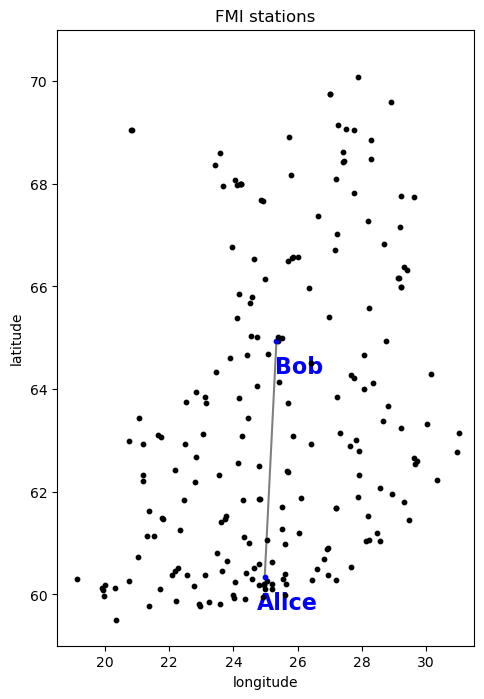

In [13]:
plotFMI(G_Alice_Bob, show_IDs=False)

### Train the local models

In [14]:
G_Alice_Bob_trained = FedGD_zero_loss(G_Alice_Bob, 
                                      zero_loss_nodes=[Bob_node_id], 
                                      alpha=10,
                                      l_rate=0.001, 
                                      max_iter=1000, 
                                      tol=0, 
                                      logging=False,
                                      n_init=20)

print(f"{G_Alice_Bob_trained.nodes[Alice_node_id]['user_name']} is located at {G_Alice_Bob_trained.nodes[Alice_node_id]['name']}")
print(f"The local model parameters are\n{G_Alice_Bob_trained.nodes[Alice_node_id]['weights']}\n")
print(f"{G_Alice_Bob_trained.nodes[Bob_node_id]['user_name']} is located at {G_Alice_Bob_trained.nodes[Bob_node_id]['name']}")
print(f"The local model parameters are\n{G_Alice_Bob_trained.nodes[Bob_node_id]['weights']}")

Running initialization 1/20
The best loss is updated: 0.13000172582799263
Initialization 1: Maximum iteration reached

Running initialization 2/20
Initialization 2: Maximum iteration reached

Running initialization 3/20
Initialization 3: Maximum iteration reached

Running initialization 4/20
Initialization 4: Maximum iteration reached

Running initialization 5/20
Initialization 5: Maximum iteration reached

Running initialization 6/20
The best loss is updated: 0.1279686052466213
Initialization 6: Maximum iteration reached

Running initialization 7/20
Initialization 7: Maximum iteration reached

Running initialization 8/20
Initialization 8: Maximum iteration reached

Running initialization 9/20
Initialization 9: Maximum iteration reached

Running initialization 10/20
Initialization 10: Maximum iteration reached

Running initialization 11/20
Initialization 11: Maximum iteration reached

Running initialization 12/20
Initialization 12: Maximum iteration reached

Running initialization 13/2

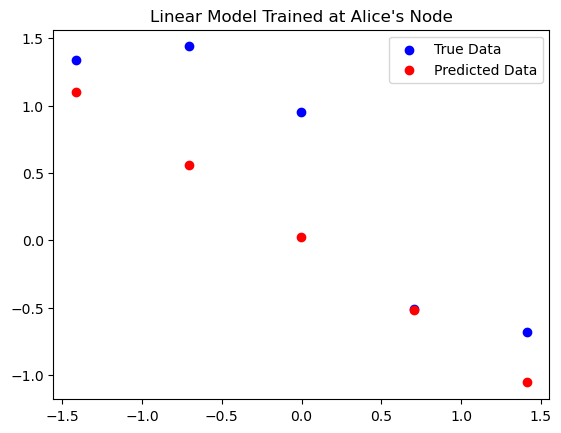

In [16]:
w_Alice = G_Alice_Bob_trained.nodes[Alice_node_id]['weights']
X_Alice = G_Alice_Bob_trained.nodes[Alice_node_id]['X_train'][:, 0].reshape(-1, 1)
y_Alice = G_Alice_Bob_trained.nodes[Alice_node_id]['y_train']

plt.scatter(X_Alice, y_Alice, c='b', label='True Data')

plt.scatter(X_Alice, X_Alice.dot(w_Alice[0, :]) + w_Alice[1, :], c='r', label='Predicted Data')

plt.title("Linear Model Trained at Alice's Node")
plt.legend()
plt.show()

### Find the Alice's location

Now that Bob's local weights replicate those of Alice, he can systematically examine all stations, compare the model weights, and infer Alice's location.

In [17]:
n_nearest = 2
w_Bob = G_Alice_Bob_trained.nodes[Bob_node_id]['weights']

delta_w = {}
for node_id, attrs in G_Alice_Bob_trained.nodes(data=True):
    w_local = attrs['weights']
    delta_w[node_id] = mean_squared_error(w_local, w_Bob)

n_nearest_nodes = sorted(delta_w.items(), key=lambda x: x[1])[:n_nearest]

n_nearest_node_ids = [node_id for node_id, _ in n_nearest_nodes]

print(f"The {n_nearest} nearest nodes based on delta_w:")
print(n_nearest_node_ids)

assert set(n_nearest_node_ids) == set([Alice_node_id, Bob_node_id])

The 2 nearest nodes based on delta_w:
[177, 81]


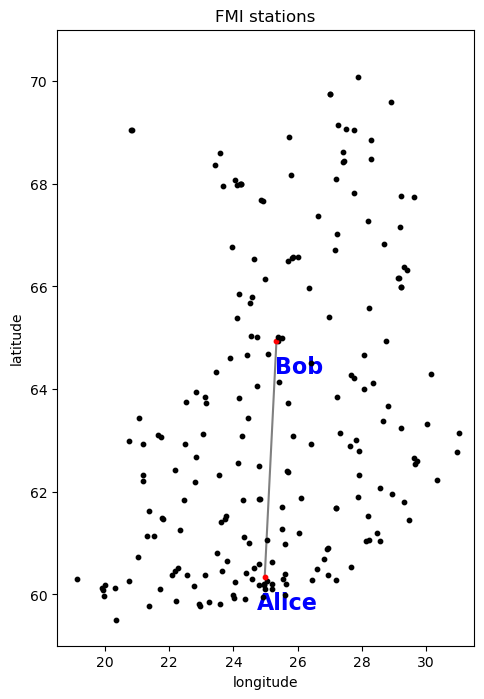

In [18]:
plotFMI(G_Alice_Bob_trained, show_IDs=False, nodes_red=n_nearest_node_ids)